In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import sys
sys.path.insert(0, os.path.dirname(os.path.abspath("")))

In [62]:
import torch
import random
import numpy as np
from PIL import Image
from datasets import load_dataset
from IPython.display import Audio
from audiodiffusion.mel import Mel
from diffusers import AutoencoderKL
from audiodiffusion import AudioDiffusionPipeline

In [42]:
mel = Mel()
vae = AutoencoderKL.from_pretrained('../models/autoencoder-kl')

In [43]:
vae.config

FrozenDict([('in_channels', 1),
            ('out_channels', 1),
            ('down_block_types',
             ['DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D']),
            ('up_block_types',
             ['UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D']),
            ('block_out_channels', [128, 256, 512, 512]),
            ('layers_per_block', 2),
            ('act_fn', 'silu'),
            ('latent_channels', 1),
            ('norm_num_groups', 32),
            ('sample_size', 256),
            ('_class_name', 'AutoencoderKL'),
            ('_diffusers_version', '0.4.1'),
            ('_name_or_path', '../models/autoencoder-kl')])

In [44]:
ds = load_dataset('teticio/audio-diffusion-256')

  0%|          | 0/1 [00:00<?, ?it/s]

### Reconstruct audio

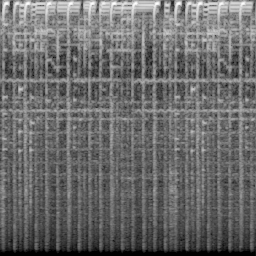

In [64]:
image = random.choice(ds['train'])['image']
display(image)
Audio(data=mel.image_to_audio(image), rate=mel.get_sample_rate())

In [65]:
# encode
input_image = np.frombuffer(image.tobytes(), dtype="uint8").reshape(
    (image.height, image.width, 1))
input_image = ((input_image / 255) * 2 - 1).transpose(2, 0, 1)
posterior = vae.encode(torch.tensor([input_image],
                                    dtype=torch.float32)).latent_dist
latents = posterior.sample()

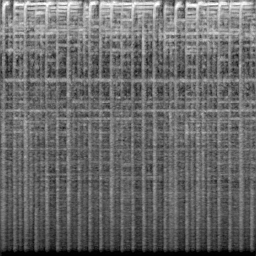

In [66]:
# reconstruct
output_image = vae.decode(latents)['sample']
output_image = torch.clamp(output_image, -1., 1.)
output_image = (output_image + 1.0) / 2.0  # -1,1 -> 0,1; c,h,w
output_image = (output_image.detach().cpu().numpy() *
                255).round().astype("uint8").transpose(0, 2, 3, 1)[0, :, :, 0]
output_image = Image.fromarray(output_image)
display(output_image)
Audio(data=mel.image_to_audio(output_image), rate=mel.get_sample_rate())

### Random sample from latent space
(Don't expect interesting results!)

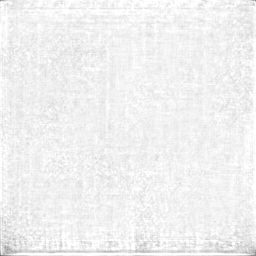

In [67]:
# sample
output_image = vae.decode(torch.randn_like(latents))['sample']
output_image = torch.clamp(output_image, -1., 1.)
output_image = (output_image + 1.0) / 2.0  # -1,1 -> 0,1; c,h,w
output_image = (output_image.detach().cpu().numpy() *
                255).round().astype("uint8").transpose(0, 2, 3, 1)[0, :, :, 0]
output_image = Image.fromarray(output_image)
display(output_image)
Audio(data=mel.image_to_audio(output_image), rate=mel.get_sample_rate())

### Interpolate between two audios in latent space

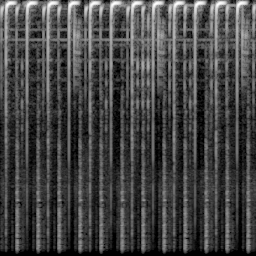

In [68]:
image2 = random.choice(ds['train'])['image']
display(image2)
Audio(data=mel.image_to_audio(image2), rate=mel.get_sample_rate())

In [69]:
# encode
input_image2 = np.frombuffer(image2.tobytes(), dtype="uint8").reshape(
    (image2.height, image2.width, 1))
input_image2 = ((input_image2 / 255) * 2 - 1).transpose(2, 0, 1)
posterior2 = vae.encode(torch.tensor([input_image2],
                                     dtype=torch.float32)).latent_dist
latents2 = posterior2.sample()

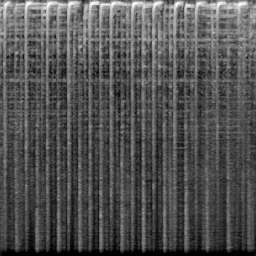

In [73]:
# interpolate
alpha = 0.5  #@param {type:"slider", min:0, max:1, step:0.1}
output_image = vae.decode(
    AudioDiffusionPipeline.slerp(latents, latents2, alpha))['sample']
output_image = torch.clamp(output_image, -1., 1.)
output_image = (output_image + 1.0) / 2.0  # -1,1 -> 0,1; c,h,w
output_image = (output_image.detach().cpu().numpy() *
                255).round().astype("uint8").transpose(0, 2, 3, 1)[0, :, :, 0]
output_image = Image.fromarray(output_image)
display(output_image)
display(Audio(data=mel.image_to_audio(image), rate=mel.get_sample_rate()))
display(Audio(data=mel.image_to_audio(image2), rate=mel.get_sample_rate()))
display(
    Audio(data=mel.image_to_audio(output_image), rate=mel.get_sample_rate()))